In [22]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseTransformer, reset_columns, self_columns

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

from source import utility as ut
from source import transform as tr
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve, plot_feat_imp, plot_partial_dependence

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 100)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

<AxesSubplot:>

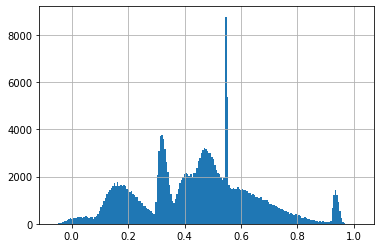

In [3]:
train_set['cont2'].hist(bins=200)

In [6]:
from sklearn.mixture import GaussianMixture

mixture = GaussianMixture(n_components=6, random_state=345).fit(train_set[['cont2']])
means_hat = mixture.means_.flatten()
weights_hat = mixture.weights_.flatten()
sds_hat = np.sqrt(mixture.covariances_).flatten()

print(mixture.converged_)
print(means_hat)
print(sds_hat)
print(weights_hat)

True
[0.67969575 0.32388798 0.5409637  0.17482154 0.93673362 0.43942046]
[0.08752462 0.01530163 0.04263455 0.0745587  0.00977342 0.04797179]
[0.17338421 0.11195566 0.20690216 0.22427974 0.02875502 0.25472321]


In [7]:
mixture.predict(train_set[['cont2']])

array([3, 2, 1, ..., 5, 0, 5])

In [8]:
tmp = train_set[['cont2']].copy()
tmp['cont2_gauss'] = mixture.predict(tmp[['cont2']])

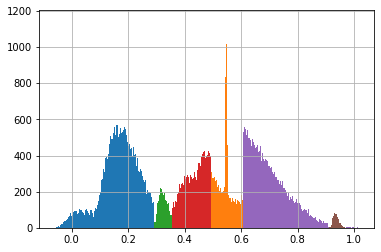

In [11]:
for val in tmp.cont2_gauss.unique():
    tmp[tmp.cont2_gauss == val].cont2.hist(bins=200)
plt.show()

In [15]:
class GaussFeat(BaseTransformer):
    def __init__(self, col_dict, random_state=1):
        super().__init__()
        self.col_dict = col_dict
        self.random_state = random_state
        self.mix_dict = {}
        for key, value in self.col_dict.items():
            self.mix_dict[key] = GaussianMixture(n_components=value, random_state=self.random_state)
     
    
    @reset_columns    
    def fit(self, X, y=None):
        
        for key in self.mix_dict.keys():
            self.mix_dict[key].fit(X[[key]])
        
        return self
    
    
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        
        for key in self.mix_dict.keys():
            X_tr[f'{key}_gauss'] = self.mix_dict[key].predict(X_tr[[key]])
        
        return X_tr

In [16]:
dist_dict = {'cont0': 5, 'cont2': 5, 'cont3': 4, 'cont4': 4, 
             'cont5': 6, 'cont6': 4, 'cont7': 6, 'cont8': 7, 
             'cont9': 9, 'cont10': 6, 'cont11': 5, 'cont12': 6, 'cont13': 7}

gauss = GaussFeat(col_dict = dist_dict, random_state=34)

In [17]:
tmp = gauss.fit_transform(train_set)

tmp.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cont0_gauss,cont2_gauss,cont3_gauss,cont4_gauss,cont5_gauss,cont6_gauss,cont7_gauss,cont8_gauss,cont9_gauss,cont10_gauss,cont11_gauss,cont12_gauss,cont13_gauss
217278,362397,A,A,A,A,B,D,A,E,G,F,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609,6.405349,4,1,1,2,1,3,1,1,1,3,1,4,4
168076,280139,A,A,A,A,B,A,A,E,A,F,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612,7.616449,1,2,1,0,1,1,2,3,0,3,4,4,0
85899,142986,B,B,A,C,B,D,A,E,G,M,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128,7.678379,1,3,3,2,1,1,5,1,1,1,1,4,3
66230,110149,A,B,A,C,B,D,A,E,G,I,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169,6.642889,4,1,0,1,2,0,1,1,7,2,4,3,1
202344,337370,A,A,A,C,B,B,A,E,C,F,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237,8.427913,2,2,0,1,3,3,1,5,3,2,0,3,3


In [23]:
class Iterator:
    def __init__(self, train, test, target_cols, seeds, n_folds, train_args, test_target=None, verbose=False):
        self.train = train
        self.test = test
        self.target_cols = target_cols
        self.seeds = seeds
        self.n_folds = n_folds
        self.train_args = train_args
        self.verbose = verbose
        self.test_target = test_target
        

    def it_seeds(self):

        oof = np.zeros(len(self.train))
        predictions = np.zeros(len(self.test))

        for seed in self.seeds:
            if self.verbose:
                print(f"SEED: {seed}")
                
            folds = KFold(self.n_folds, shuffle=True, random_state=seed)

            oof_seed, predictions_seed, rep_res_seed = train_model(train_df=self.train, test_df=self.test, target=self.target_cols, 
                                                                   cv=folds, **self.train_args)
            
            if self.verbose:
                print(f'\tIteations for early stopping: {rep_res_seed["n_iterations"]}')

                print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(self.target_cols, oof_seed)), 4)}')
                if self.test_target is not None:
                    print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(self.test_target, predictions_seed)), 4)}')
            
            oof += oof_seed / len(self.seeds)
            predictions += predictions_seed / len(self.seeds)
            
        if self.verbose:
            print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(self.target_cols, oof)), 4)}')
            if self.test_target is not None:
                print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(self.test_target, predictions)), 4)}')

        return oof, predictions

In [24]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

for col in [col for col in train_set if 'cat' in col]:
    le = LabelEncoder()
    train_set[col] = le.fit_transform(train_set[col])
    test_set[col] = le.transform(test_set[col])

In [25]:
SEEDS = [541, 75]

SEED: 541
	Iteations for early stopping: [2437, 2841, 2004, 2411, 1943, 3058, 2507, 3093, 2016, 2982]
	Train set RMSE: 0.8427
	Test set RMSE: 0.8432
SEED: 75
	Iteations for early stopping: [2446, 2352, 2953, 1826, 2902, 2875, 2537, 1910, 2366, 3083]
	Train set RMSE: 0.8428
	Test set RMSE: 0.8432
Train set RMSE: 0.8425
Test set RMSE: 0.8432


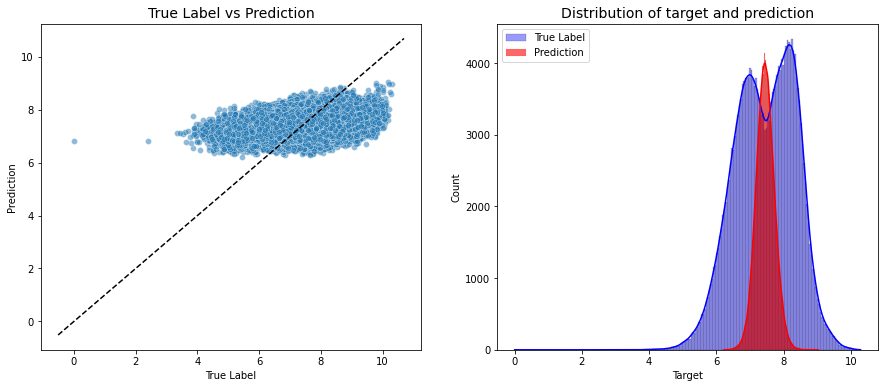

CPU times: user 1h 6min 20s, sys: 5min 52s, total: 1h 12min 13s
Wall time: 12min 20s


In [26]:
%%time

params = { 'reg_lambda': 0.016, 
          'reg_alpha': 9.1, 
          'colsample_bytree': 0.3, 
          'subsample': 1.0, 
          'learning_rate': 0.009, 
          'max_depth': 15, 
          'min_child_samples': 142, 
          'num_leaves': 84, 
          'random_state': 42}

full_pipe = Pipeline([('gauss', GaussFeat(col_dict = dist_dict, random_state=34)), ('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

train_param = {'trsf_pipe': full_pipe, 'estimator': mod, 'early_stopping': 1000}

iterator = Iterator(train_set, test_set, y, SEEDS, 10, train_param, y_test, True)

oof, preds = iterator.it_seeds()

plot_regression_predictions(train_set, y, oof)